In [5]:
pip install tensorflow scikit-learn matplotlib numpy pillow seaborn

Note: you may need to restart the kernel to use updated packages.


Found 6259 images belonging to 10 classes.
Found 1322 images belonging to 10 classes.
Found 1364 images belonging to 10 classes.
Epoch 1/50
195/195 [==============================] - 289s 1s/step - loss: 2.2517 - accuracy: 0.1646 - val_loss: 2.3042 - val_accuracy: 0.1037
Epoch 2/50
195/195 [==============================] - 266s 1s/step - loss: 2.1499 - accuracy: 0.1925 - val_loss: 2.3308 - val_accuracy: 0.1037
Epoch 3/50
195/195 [==============================] - 270s 1s/step - loss: 2.1003 - accuracy: 0.2165 - val_loss: 2.3598 - val_accuracy: 0.0968
Epoch 4/50
195/195 [==============================] - 266s 1s/step - loss: 2.0596 - accuracy: 0.2296 - val_loss: 2.4499 - val_accuracy: 0.1037
Epoch 5/50
195/195 [==============================] - 265s 1s/step - loss: 2.0286 - accuracy: 0.2512 - val_loss: 2.4467 - val_accuracy: 0.0960
Epoch 6/50
195/195 [==============================] - 267s 1s/step - loss: 1.9942 - accuracy: 0.2685 - val_loss: 2.5332 - val_accuracy: 0.1037
Epoch 7/50
19

C:\Users\User\anaconda3\envs\ISB46703\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


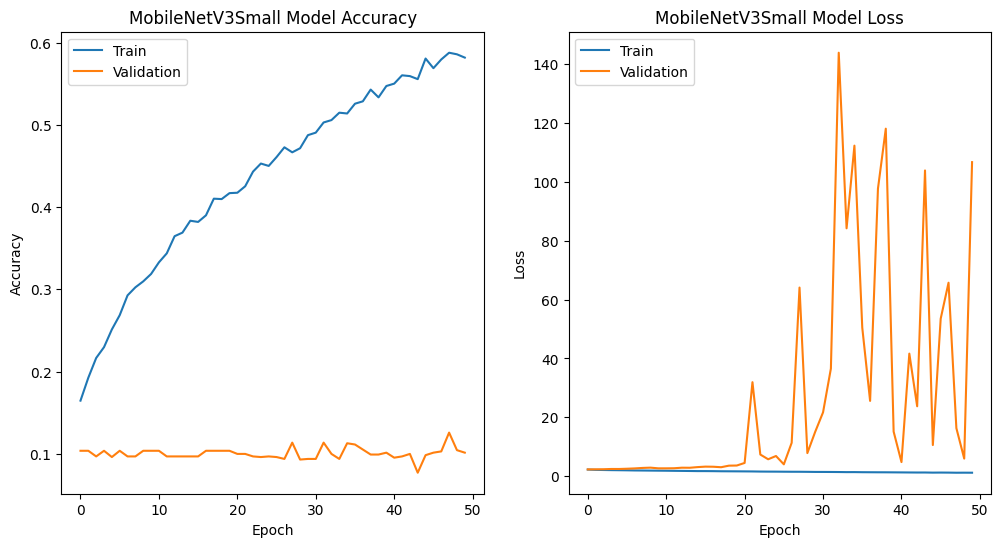

43/43 [==============================] - 13s 290ms/step
MobileNetV3Small - Test Accuracy: 0.0915178582072258
MobileNetV3Small - Test mAP: 0.10001347926136836


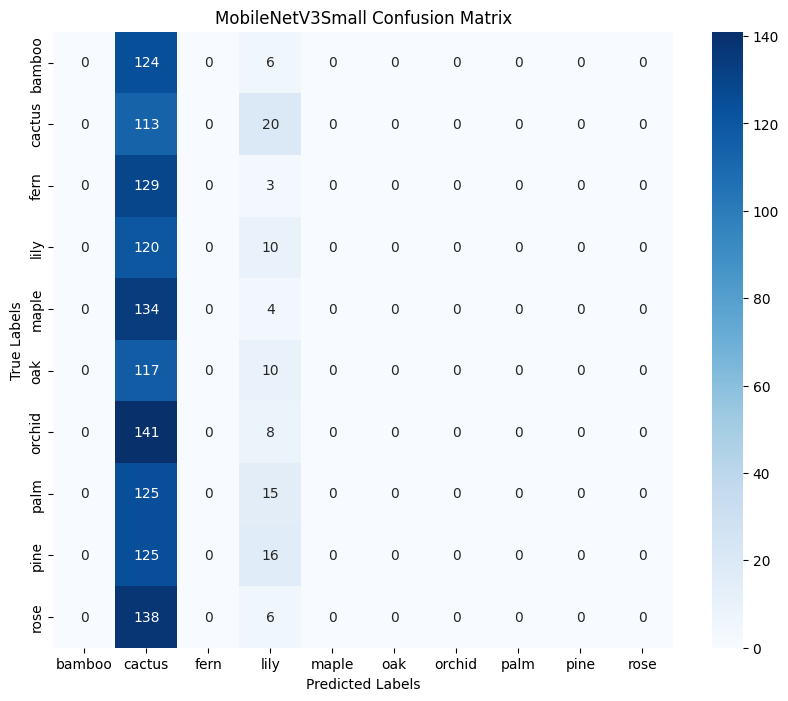

Classification Report for MobileNetV3Small:
              precision    recall  f1-score   support

      bamboo       0.00      0.00      0.00       130
      cactus       0.09      0.85      0.16       133
        fern       0.00      0.00      0.00       132
        lily       0.10      0.08      0.09       130
       maple       0.00      0.00      0.00       138
         oak       0.00      0.00      0.00       127
      orchid       0.00      0.00      0.00       149
        palm       0.00      0.00      0.00       140
        pine       0.00      0.00      0.00       141
        rose       0.00      0.00      0.00       144

    accuracy                           0.09      1364
   macro avg       0.02      0.09      0.02      1364
weighted avg       0.02      0.09      0.02      1364



C:\Users\User\anaconda3\envs\ISB46703\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\envs\ISB46703\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\envs\ISB46703\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [1]:
import warnings
import re

# Suppress specific warnings
warnings.filterwarnings("ignore", category=UserWarning, message="Palette images with Transparency")

# Escape special characters in the PyDataset warning message
pydataset_warning_message = r"Your `PyDataset` class should call `super\(\)\.__init__\(\*\*kwargs\)` in its constructor"
warnings.filterwarnings("ignore", category=UserWarning, message=re.escape(pydataset_warning_message))

import tensorflow as tf
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import average_precision_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np
import time
import os
from PIL import Image
import seaborn as sns

# Define function to calculate mAP (mean Average Precision)
def calculate_mAP(y_true, y_pred):
    mAP = []
    for i in range(len(y_true[0])):
        mAP.append(average_precision_score(y_true[:, i], y_pred[:, i]))
    return np.mean(mAP)

# Define paths to your dataset directories
train_data_dir = r'C:\Users\User\Desktop\AI\plant_subspecies_split/train'
validation_data_dir = r'C:\Users\User\Desktop\AI\plant_subspecies_split/val'
test_data_dir = r'C:\Users\User\Desktop\AI\plant_subspecies_split/test'

# Function to remove corrupted images
def remove_corrupted_images(directory):
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                img = Image.open(file_path)
                img.verify()
                img.close()
            except (IOError, SyntaxError) as e:
                print(f"Removing corrupted image: {file_path}")
                os.remove(file_path)

# Remove corrupted images
remove_corrupted_images(train_data_dir)
remove_corrupted_images(validation_data_dir)
remove_corrupted_images(test_data_dir)

# Enhanced ImageDataGenerator class
class CustomImageDataGenerator(ImageDataGenerator):
    def flow_from_directory(self, *args, **kwargs):
        gen = super().flow_from_directory(*args, **kwargs)
        self.samples = gen.samples
        self.num_classes = gen.num_classes
        return gen

# Define image data generators
train_datagen = CustomImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = CustomImageDataGenerator(rescale=1./255)
test_datagen = CustomImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Number of classes in your dataset
num_classes = train_generator.num_classes

# Build and compile MobileNetV3Small model
model_mobilenetv3small = MobileNetV3Small(weights=None, include_top=True, input_shape=(224, 224, 3), classes=num_classes)
model_mobilenetv3small.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
start_time = time.time()
history_mobilenetv3small = model_mobilenetv3small.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,
    epochs=50,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // 32
)
training_time_mobilenetv3small = time.time() - start_time

# Evaluate the model on validation set
val_loss, val_accuracy = model_mobilenetv3small.evaluate(valid_generator, steps=valid_generator.samples // 32)

# Calculate mAP on the validation set
valid_generator.reset()
val_predictions = model_mobilenetv3small.predict(valid_generator, steps=valid_generator.samples // 32 + 1)
val_true = valid_generator.classes[:len(val_predictions)]
val_true = tf.keras.utils.to_categorical(val_true, num_classes=num_classes)
val_mAP = calculate_mAP(val_true, val_predictions)

print(f'MobileNetV3Small - Validation Accuracy: {val_accuracy}')
print(f'MobileNetV3Small - Validation mAP: {val_mAP}')
print(f'MobileNetV3Small - Training Time: {training_time_mobilenetv3small}')

# Save the trained model
model_mobilenetv3small.save(r'C:\Users\User\Desktop\AI\plant_subspecies_split/MobileNetV3Small_plant_subspecies.h5')

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_mobilenetv3small.history['accuracy'])
plt.plot(history_mobilenetv3small.history['val_accuracy'])
plt.title('MobileNetV3Small Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_mobilenetv3small.history['loss'])
plt.plot(history_mobilenetv3small.history['val_loss'])
plt.title('MobileNetV3Small Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Evaluate the model on the test set
test_loss, test_accuracy = model_mobilenetv3small.evaluate(test_generator, steps=test_generator.samples // 32)

# Calculate mAP on the test set
test_generator.reset()
test_predictions = model_mobilenetv3small.predict(test_generator, steps=test_generator.samples // 32 + 1)
test_true = test_generator.classes[:len(test_predictions)]
test_true = tf.keras.utils.to_categorical(test_true, num_classes=num_classes)
test_mAP = calculate_mAP(test_true, test_predictions)

print(f'MobileNetV3Small - Test Accuracy: {test_accuracy}')
print(f'MobileNetV3Small - Test mAP: {test_mAP}')

# Confusion Matrix
test_predictions_classes = np.argmax(test_predictions, axis=1)
conf_matrix = confusion_matrix(test_generator.classes, test_predictions_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices, yticklabels=test_generator.class_indices)
plt.title('MobileNetV3Small Confusion Matrix')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()

# Classification Report
class_labels = list(test_generator.class_indices.keys())
class_report = classification_report(test_generator.classes, test_predictions_classes, target_names=list(test_generator.class_indices.keys()))
print('Classification Report for MobileNetV3Small:')
print(class_report)
